In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load datasets
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Transactions.csv')

In [ ]:
# Merge datasets to create a comprehensive dataset
merged_data = transactions.merge(customers, on='CustomerID', how='left')

In [ ]:
# Aggregating data to create customer profiles
customer_profiles = (
    merged_data.groupby('CustomerID')
    .agg({
        'TotalValue': 'sum',  # Total revenue
        'Quantity': 'sum',   # Total quantity purchased
        'TransactionID': 'count',  # Number of transactions
        'Region': 'first'  # Region of the customer
    })
    .reset_index()
)

In [ ]:
# One-hot encode the 'Region' column
region_dummies = pd.get_dummies(customer_profiles['Region'], prefix='Region')
customer_profiles = pd.concat([customer_profiles, region_dummies], axis=1)
customer_profiles = customer_profiles.drop(columns=['Region'])

In [ ]:
# Normalize numerical features for clustering
scaler = MinMaxScaler()
numerical_features = ['TotalValue', 'Quantity', 'TransactionID']
customer_profiles[numerical_features] = scaler.fit_transform(customer_profiles[numerical_features])

In [ ]:
# Step 1: Apply K-Means Clustering
db_index_scores = []
for k in range(2, 11):  # Trying clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customer_profiles.drop(columns=['CustomerID']))
    db_index = davies_bouldin_score(customer_profiles.drop(columns=['CustomerID']), labels)
    db_index_scores.append((k, db_index))

# Find the best number of clusters (lowest DB Index)
best_k, best_db_index = min(db_index_scores, key=lambda x: x[1])

# Re-run K-Means with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(customer_profiles.drop(columns=['CustomerID']))


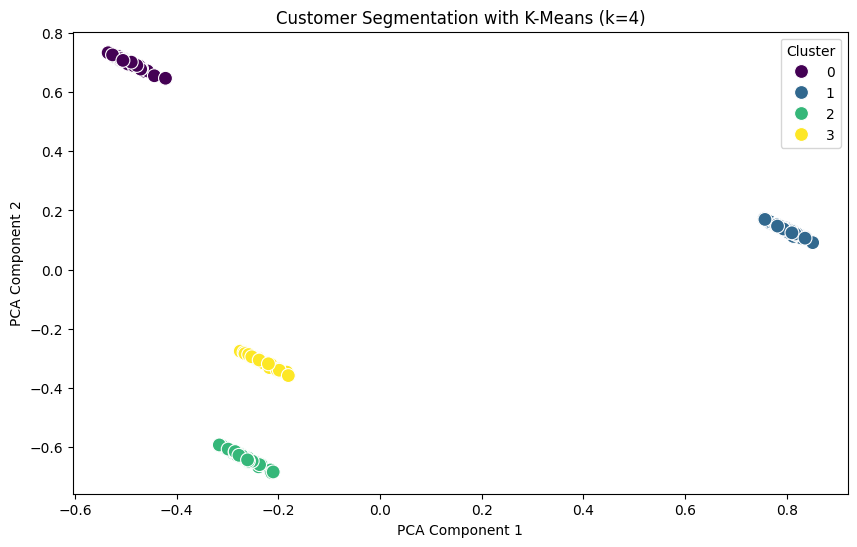

In [ ]:
# Step 2: Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(customer_profiles.drop(columns=['CustomerID', 'Cluster']))
customer_profiles['PCA1'] = pca_features[:, 0]
customer_profiles['PCA2'] = pca_features[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_profiles, palette='viridis', s=100
)
plt.title(f'Customer Segmentation with K-Means (k={best_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [ ]:
# Step 3: Output Clustering Metrics
print(f"Best number of clusters: {best_k}")
print(f"Davies-Bouldin Index for k={best_k}: {best_db_index:.4f}")

Best number of clusters: 4
Davies-Bouldin Index for k=4: 0.4313
